In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

# cv

In [9]:
from sklearn.linear_model import Ridge

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0', 'const_one', 'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28', 'all_count_y1', 'geo1_count_y1', 'station_count_y1', 'geo2_count_y1', 'all_count_y2', 'geo1_count_y2', 'station_count_y2', 'geo2_count_y2', 'all_count_y3', 'geo1_count_y3', 'station_count_y3', 'geo2_count_y3', 'all_count_y4', 'geo1_count_y4', 'station_count_y4', 'geo2_count_y4', 'all_count_y5', 'geo1_count_y5', 'station_count_y5', 'geo2_count_y5', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'holiday', 's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio', 'f_t', 'bad_ratio', 'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean']
len(lag_cols)

72

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        gbm = Ridge()
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        scores.append(mean_squared_error(validy,validpred))
        print mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X=np.concatenate([X,np.isnan(X)],1)
        X[np.isnan(X)]=0        
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=True
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3000eb_ridge_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (164247, 2) (39706, 2)


rand split across time
train has 164247 records out of 389630 records
valid has 39706 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1283
0


(164247, 1, 18) (164247, 7, 72) (164247, 1) (164247, 1)


(164247, 522) (164247,) (164247,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(5803, 1, 18) (5803, 7, 72) (5803, 1) (5803, 1)
(5803, 522) (5803,) (5803,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.13270008492e-11 / 5.96046447754e-08
  RuntimeWarning)


0.0953322 0.285807
[0.28580666]
-1 mean score 0.285807


0.238771


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.968117 -0.039007  0.270559    7  2017-04-16
472     2.507290  2.579356 -0.072066  0.265946    1  2017-04-17
473     2.661330  2.667711 -0.006382  0.283722    2  2017-04-18
474     2.754815  2.771669 -0.016854  0.229775    3  2017-04-19
475     2.713762  2.755281 -0.041519  0.252828    4  2017-04-20
476     2.999000  2.987772  0.011227  0.164699    5  2017-04-21
477     3.075529  3.108297 -0.032767  0.203864    6  2017-04-22

0.238771


pred         y     error    error2  day        date
dayidx                                                         
471     2.968117  2.929110 -0.039007  0.270559    7  2017-04-16
472     2.579356  2.507290 -0.072066  0.265946    1  2017-04-17
473     2.667711  2.661330 -0.006382  0.283722    2  2017-04-18
474     2.771669  2.754815 -0.016854  0.229775    3  2017-04-19
475     2.755281  2.713762 -0.041519  0.252828    4  2017-04-20
476     2.987772  2.999000  0.011227  0.164699    5  2017-04-21
477     3.108297  3.075529 -0.032767  0.203864    6  2017-04-22

(829, 1044)




2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (169458, 2) (41130, 2)


rand split across time
train has 169458 records out of 389630 records
valid has 41130 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1323
0


(169458, 1, 18) (169458, 7, 72) (169458, 1) (169458, 1)
(169458, 522) (169458,) (169458,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(6632, 1, 18) (6632, 7, 72) (6632, 1) (6632, 1)
(6632, 522) (6632,) (6632,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.34285124423e-11 / 5.96046447754e-08
  RuntimeWarning)


0.0978849 0.281526
[0.28152588]
-1 mean score 0.281526
0.23923


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.950076 -0.020966  0.270570    7  2017-04-16
472     2.507290  2.588318 -0.081028  0.264778    1  2017-04-17
473     2.661330  2.687980 -0.026650  0.283464    2  2017-04-18
474     2.754815  2.776077 -0.021263  0.233611    3  2017-04-19
475     2.713762  2.758512 -0.044750  0.253553    4  2017-04-20
476     2.999000  3.004258 -0.005258  0.168273    5  2017-04-21
477     3.075529  3.083198 -0.007669  0.200362    6  2017-04-22

0.23923


pred         y     error    error2  day        date
dayidx                                                         
471     2.950076  2.929110 -0.020966  0.270570    7  2017-04-16
472     2.588318  2.507290 -0.081028  0.264778    1  2017-04-17
473     2.687980  2.661330 -0.026650  0.283464    2  2017-04-18
474     2.776077  2.754815 -0.021263  0.233611    3  2017-04-19
475     2.758512  2.713762 -0.044750  0.253553    4  2017-04-20
476     3.004258  2.999000 -0.005258  0.168273    5  2017-04-21
477     3.083198  3.075529 -0.007669  0.200362    6  2017-04-22

(829, 1044)




3


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (169820, 2) (41350, 2)


rand split across time
train has 169820 records out of 389630 records
valid has 41350 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1326
0


(169820, 1, 18) (169820, 7, 72) (169820, 1) (169820, 1)


(169820, 522) (169820,) (169820,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(7461, 1, 18) (7461, 7, 72) (7461, 1) (7461, 1)
(7461, 522) (7461,) (7461,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.0033726334e-11 / 5.96046447754e-08
  RuntimeWarning)


0.099451 0.28305
[0.28304967]
-1 mean score 0.28305
0.240473


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.941586 -0.012476  0.269801    7  2017-04-16
472     2.507290  2.591046 -0.083755  0.265850    1  2017-04-17
473     2.661330  2.673967 -0.012637  0.284753    2  2017-04-18
474     2.754815  2.782247 -0.027432  0.234681    3  2017-04-19
475     2.713762  2.760058 -0.046297  0.257669    4  2017-04-20
476     2.999000  2.999052 -0.000052  0.170220    5  2017-04-21
477     3.075529  3.095411 -0.019881  0.200336    6  2017-04-22

0.240473


pred         y     error    error2  day        date
dayidx                                                         
471     2.941586  2.929110 -0.012477  0.269801    7  2017-04-16
472     2.591046  2.507290 -0.083755  0.265850    1  2017-04-17
473     2.673967  2.661330 -0.012637  0.284753    2  2017-04-18
474     2.782247  2.754815 -0.027432  0.234681    3  2017-04-19
475     2.760058  2.713762 -0.046297  0.257669    4  2017-04-20
476     2.999052  2.999000 -0.000052  0.170220    5  2017-04-21
477     3.095411  3.075529 -0.019881  0.200336    6  2017-04-22

(829, 1044)




4


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (169973, 2) (41322, 2)


rand split across time
train has 169973 records out of 389630 records
valid has 41322 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1327
0


(169973, 1, 18) (169973, 7, 72) (169973, 1) (169973, 1)


(169973, 522) (169973,) (169973,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(8290, 1, 18) (8290, 7, 72) (8290, 1) (8290, 1)
(8290, 522) (8290,) (8290,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.86586053967e-13 / 5.96046447754e-08
  RuntimeWarning)


0.100268 0.285582
[0.28558171]
-1 mean score 0.285582
0.241939


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.929609 -0.000499  0.270757    7  2017-04-16
472     2.507290  2.602068 -0.094778  0.268369    1  2017-04-17
473     2.661330  2.659518  0.001812  0.286136    2  2017-04-18
474     2.754815  2.767770 -0.012955  0.233430    3  2017-04-19
475     2.713762  2.756255 -0.042494  0.262153    4  2017-04-20
476     2.999000  2.974401  0.024599  0.172457    5  2017-04-21
477     3.075529  3.092646 -0.017117  0.200272    6  2017-04-22

0.241939


pred         y     error    error2  day        date
dayidx                                                         
471     2.929609  2.929110 -0.000499  0.270757    7  2017-04-16
472     2.602068  2.507290 -0.094778  0.268369    1  2017-04-17
473     2.659518  2.661330  0.001812  0.286136    2  2017-04-18
474     2.767770  2.754815 -0.012955  0.233430    3  2017-04-19
475     2.756255  2.713762 -0.042494  0.262153    4  2017-04-20
476     2.974401  2.999000  0.024599  0.172457    5  2017-04-21
477     3.092646  3.075529 -0.017117  0.200272    6  2017-04-22

(829, 1044)




5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (170198, 2) (41294, 2)


rand split across time
train has 170198 records out of 389630 records
valid has 41294 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1329
0


(170198, 1, 18) (170198, 7, 72) (170198, 1) (170198, 1)
(170198, 522) (170198,) (170198,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(9119, 1, 18) (9119, 7, 72) (9119, 1) (9119, 1)
(9119, 522) (9119,) (9119,)


0.100947 0.287133
[0.28713301]
-1 mean score 0.287133
0.242241


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.948026 -0.018916  0.271610    7  2017-04-16
472     2.507290  2.597295 -0.090005  0.267890    1  2017-04-17
473     2.661330  2.661699 -0.000369  0.286782    2  2017-04-18
474     2.754815  2.754561  0.000254  0.233758    3  2017-04-19
475     2.713762  2.751056 -0.037294  0.260732    4  2017-04-20
476     2.999000  2.977492  0.021508  0.172987    5  2017-04-21
477     3.075529  3.079943 -0.004414  0.201927    6  2017-04-22

0.242241


pred         y     error    error2  day        date
dayidx                                                         
471     2.948026  2.929110 -0.018916  0.271610    7  2017-04-16
472     2.597295  2.507290 -0.090005  0.267890    1  2017-04-17
473     2.661699  2.661330 -0.000369  0.286782    2  2017-04-18
474     2.754561  2.754815  0.000254  0.233758    3  2017-04-19
475     2.751056  2.713762 -0.037294  0.260732    4  2017-04-20
476     2.977492  2.999000  0.021508  0.172987    5  2017-04-21
477     3.079943  3.075529 -0.004414  0.201927    6  2017-04-22

(829, 1044)




6


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 15.1334


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (170177, 2) (41240, 2)


rand split across time
train has 170177 records out of 389630 records
valid has 41240 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1329
0


(170177, 1, 18) (170177, 7, 72) (170177, 1) (170177, 1)


(170177, 522) (170177,) (170177,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(9948, 1, 18) (9948, 7, 72) (9948, 1) (9948, 1)
(9948, 522) (9948,) (9948,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.22604398592e-11 / 5.96046447754e-08
  RuntimeWarning)


0.101839 0.290361
[0.29036114]
-1 mean score 0.290361
0.243597


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.945100 -0.015990  0.271798    7  2017-04-16
472     2.507290  2.603235 -0.095945  0.270139    1  2017-04-17
473     2.661330  2.660230  0.001100  0.288802    2  2017-04-18
474     2.754815  2.758231 -0.003416  0.233379    3  2017-04-19
475     2.713762  2.747273 -0.033512  0.261610    4  2017-04-20
476     2.999000  2.962285  0.036715  0.175573    5  2017-04-21
477     3.075529  3.099358 -0.023829  0.203881    6  2017-04-22

0.243597


pred         y     error    error2  day        date
dayidx                                                         
471     2.945100  2.929110 -0.015990  0.271798    7  2017-04-16
472     2.603235  2.507290 -0.095945  0.270139    1  2017-04-17
473     2.660230  2.661330  0.001100  0.288802    2  2017-04-18
474     2.758231  2.754815 -0.003416  0.233379    3  2017-04-19
475     2.747273  2.713762 -0.033512  0.261610    4  2017-04-20
476     2.962285  2.999000  0.036715  0.175573    5  2017-04-21
477     3.099358  3.075529 -0.023829  0.203881    6  2017-04-22

(829, 1044)




7


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 16.3101


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (170518, 2) (41367, 2)


rand split across time
train has 170518 records out of 389630 records
valid has 41367 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1332
0


(170518, 1, 18) (170518, 7, 72) (170518, 1) (170518, 1)


(170518, 522) (170518,) (170518,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(10777, 1, 18) (10777, 7, 72) (10777, 1) (10777, 1)
(10777, 522) (10777,) (10777,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.36746697036e-11 / 5.96046447754e-08
  RuntimeWarning)


0.102911 0.284755
[0.28475502]
-1 mean score 0.284755
0.244418


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.943720 -0.014610  0.270772    7  2017-04-16
472     2.507290  2.619379 -0.112089  0.278194    1  2017-04-17
473     2.661330  2.678880 -0.017550  0.292479    2  2017-04-18
474     2.754815  2.750474  0.004341  0.236625    3  2017-04-19
475     2.713762  2.747163 -0.033401  0.260431    4  2017-04-20
476     2.999000  2.972071  0.026929  0.173445    5  2017-04-21
477     3.075529  3.106818 -0.031289  0.198982    6  2017-04-22

0.244418


pred         y     error    error2  day        date
dayidx                                                         
471     2.943720  2.929110 -0.014610  0.270772    7  2017-04-16
472     2.619379  2.507290 -0.112089  0.278194    1  2017-04-17
473     2.678880  2.661330 -0.017550  0.292479    2  2017-04-18
474     2.750474  2.754815  0.004341  0.236625    3  2017-04-19
475     2.747163  2.713762 -0.033401  0.260431    4  2017-04-20
476     2.972071  2.999000  0.026929  0.173445    5  2017-04-21
477     3.106818  3.075529 -0.031289  0.198982    6  2017-04-22

(829, 1044)




8


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 17.5743


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (169930, 2) (41203, 2)


rand split across time
train has 169930 records out of 389630 records
valid has 41203 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1327
0


(169930, 1, 18) (169930, 7, 72) (169930, 1) (169930, 1)


(169930, 522) (169930,) (169930,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(11606, 1, 18) (11606, 7, 72) (11606, 1) (11606, 1)
(11606, 522) (11606,) (11606,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.31398260328e-11 / 5.96046447754e-08
  RuntimeWarning)


0.111202 0.282233
[0.28223342]
-1 mean score 0.282233
0.25284


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.969322 -0.040212  0.283898    7  2017-04-16
472     2.507290  2.628898 -0.121608  0.279967    1  2017-04-17
473     2.661330  2.705479 -0.044149  0.299645    2  2017-04-18
474     2.754815  2.769842 -0.015028  0.252613    3  2017-04-19
475     2.713762  2.744591 -0.030829  0.268488    4  2017-04-20
476     2.999000  2.989504  0.009495  0.182942    5  2017-04-21
477     3.075529  3.113408 -0.037878  0.202330    6  2017-04-22

0.25284


pred         y     error    error2  day        date
dayidx                                                         
471     2.969322  2.929110 -0.040212  0.283898    7  2017-04-16
472     2.628898  2.507290 -0.121608  0.279967    1  2017-04-17
473     2.705479  2.661330 -0.044149  0.299645    2  2017-04-18
474     2.769842  2.754815 -0.015028  0.252613    3  2017-04-19
475     2.744591  2.713762 -0.030829  0.268488    4  2017-04-20
476     2.989504  2.999000  0.009495  0.182942    5  2017-04-21
477     3.113408  3.075529 -0.037878  0.202330    6  2017-04-22

(829, 1044)




9


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 18.8065


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (170873, 2) (41502, 2)


rand split across time
train has 170873 records out of 389630 records
valid has 41502 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1334
0


(170873, 1, 18) (170873, 7, 72) (170873, 1) (170873, 1)


(170873, 522) (170873,) (170873,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(12435, 1, 18) (12435, 7, 72) (12435, 1) (12435, 1)
(12435, 522) (12435,) (12435,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.95432894499e-11 / 5.96046447754e-08
  RuntimeWarning)


0.112487 0.292885
[0.29288545]
-1 mean score 0.292885
0.252789


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.961991 -0.032881  0.282004    7  2017-04-16
472     2.507290  2.628306 -0.121016  0.280177    1  2017-04-17
473     2.661330  2.718621 -0.057292  0.306266    2  2017-04-18
474     2.754815  2.775234 -0.020419  0.250906    3  2017-04-19
475     2.713762  2.750934 -0.037172  0.267762    4  2017-04-20
476     2.999000  2.982052  0.016947  0.181629    5  2017-04-21
477     3.075529  3.101833 -0.026304  0.200782    6  2017-04-22

0.252789


pred         y     error    error2  day        date
dayidx                                                         
471     2.961991  2.929110 -0.032881  0.282004    7  2017-04-16
472     2.628306  2.507290 -0.121016  0.280177    1  2017-04-17
473     2.718621  2.661330 -0.057292  0.306266    2  2017-04-18
474     2.775234  2.754815 -0.020419  0.250906    3  2017-04-19
475     2.750934  2.713762 -0.037172  0.267762    4  2017-04-20
476     2.982052  2.999000  0.016947  0.181629    5  2017-04-21
477     3.101833  3.075529 -0.026304  0.200782    6  2017-04-22

(829, 1044)




10


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 19.9265


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (170970, 2) (41541, 2)


rand split across time
train has 170970 records out of 389630 records
valid has 41541 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1335
0


(170970, 1, 18) (170970, 7, 72) (170970, 1) (170970, 1)
(170970, 522) (170970,) (170970,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(13264, 1, 18) (13264, 7, 72) (13264, 1) (13264, 1)
(13264, 522) (13264,) (13264,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.59084714688e-11 / 5.96046447754e-08
  RuntimeWarning)


0.113262 0.295567
[0.29556686]
-1 mean score 0.295567
0.253303


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.962593 -0.033483  0.284542    7  2017-04-16
472     2.507290  2.628539 -0.121248  0.278443    1  2017-04-17
473     2.661330  2.709714 -0.048384  0.307129    2  2017-04-18
474     2.754815  2.767173 -0.012358  0.252872    3  2017-04-19
475     2.713762  2.755221 -0.041460  0.269935    4  2017-04-20
476     2.999000  2.994197  0.004802  0.180723    5  2017-04-21
477     3.075529  3.084834 -0.009305  0.199475    6  2017-04-22

0.253303


pred         y     error    error2  day        date
dayidx                                                         
471     2.962593  2.929110 -0.033483  0.284542    7  2017-04-16
472     2.628539  2.507290 -0.121248  0.278443    1  2017-04-17
473     2.709714  2.661330 -0.048384  0.307129    2  2017-04-18
474     2.767173  2.754815 -0.012358  0.252872    3  2017-04-19
475     2.755221  2.713762 -0.041460  0.269935    4  2017-04-20
476     2.994197  2.999000  0.004802  0.180723    5  2017-04-21
477     3.084834  3.075529 -0.009305  0.199475    6  2017-04-22

(829, 1044)




11


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 21.0577


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (170871, 2) (41594, 2)


rand split across time
train has 170871 records out of 389630 records
valid has 41594 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1334
0


(170871, 1, 18) (170871, 7, 72) (170871, 1) (170871, 1)
(170871, 522) (170871,) (170871,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(14093, 1, 18) (14093, 7, 72) (14093, 1) (14093, 1)
(14093, 522) (14093,) (14093,)


0.113649 0.295106
[0.29510638]
-1 mean score 0.295106
0.253038


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.954345 -0.025236  0.283964    7  2017-04-16
472     2.507290  2.636603 -0.129313  0.281534    1  2017-04-17
473     2.661330  2.715700 -0.054370  0.306249    2  2017-04-18
474     2.754815  2.751826  0.002989  0.250544    3  2017-04-19
475     2.713762  2.743834 -0.030072  0.270403    4  2017-04-20
476     2.999000  3.002040 -0.003040  0.178282    5  2017-04-21
477     3.075529  3.098210 -0.022680  0.200288    6  2017-04-22

0.253038


pred         y     error    error2  day        date
dayidx                                                         
471     2.954345  2.929110 -0.025236  0.283964    7  2017-04-16
472     2.636603  2.507290 -0.129313  0.281534    1  2017-04-17
473     2.715700  2.661330 -0.054370  0.306249    2  2017-04-18
474     2.751826  2.754815  0.002989  0.250544    3  2017-04-19
475     2.743834  2.713762 -0.030072  0.270403    4  2017-04-20
476     3.002040  2.999000 -0.003040  0.178282    5  2017-04-21
477     3.098210  3.075529 -0.022680  0.200288    6  2017-04-22

(829, 1044)




12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 22.1151


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (170942, 2) (41544, 2)


rand split across time
train has 170942 records out of 389630 records
valid has 41544 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1335
0


(170942, 1, 18) (170942, 7, 72) (170942, 1) (170942, 1)
(170942, 522) (170942,) (170942,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(14922, 1, 18) (14922, 7, 72) (14922, 1) (14922, 1)
(14922, 522) (14922,) (14922,)


0.113515 0.296495
[0.29649526]
-1 mean score 0.296495
0.254629


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.970809 -0.041699  0.284958    7  2017-04-16
472     2.507290  2.645119 -0.137829  0.284223    1  2017-04-17
473     2.661330  2.724967 -0.063638  0.306455    2  2017-04-18
474     2.754815  2.764607 -0.009792  0.253853    3  2017-04-19
475     2.713762  2.735076 -0.021315  0.270297    4  2017-04-20
476     2.999000  2.991642  0.007358  0.181084    5  2017-04-21
477     3.075529  3.105341 -0.029812  0.201533    6  2017-04-22

0.254629


pred         y     error    error2  day        date
dayidx                                                         
471     2.970809  2.929110 -0.041699  0.284958    7  2017-04-16
472     2.645119  2.507290 -0.137829  0.284223    1  2017-04-17
473     2.724967  2.661330 -0.063638  0.306455    2  2017-04-18
474     2.764607  2.754815 -0.009792  0.253853    3  2017-04-19
475     2.735076  2.713762 -0.021315  0.270297    4  2017-04-20
476     2.991642  2.999000  0.007358  0.181084    5  2017-04-21
477     3.105341  3.075529 -0.029812  0.201533    6  2017-04-22

(829, 1044)




13


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 23.1552


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (170934, 2) (41475, 2)


rand split across time
train has 170934 records out of 389630 records
valid has 41475 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1335
0


(170934, 1, 18) (170934, 7, 72) (170934, 1) (170934, 1)
(170934, 522) (170934,) (170934,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(15751, 1, 18) (15751, 7, 72) (15751, 1) (15751, 1)
(15751, 522) (15751,) (15751,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.87884332828e-11 / 5.96046447754e-08
  RuntimeWarning)


0.11392 0.297304
[0.29730389]
-1 mean score 0.297304
0.255277


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.968436 -0.039327  0.288797    7  2017-04-16
472     2.507290  2.657133 -0.149842  0.287087    1  2017-04-17
473     2.661330  2.720018 -0.058688  0.305578    2  2017-04-18
474     2.754815  2.765804 -0.010989  0.253000    3  2017-04-19
475     2.713762  2.744208 -0.030447  0.270897    4  2017-04-20
476     2.999000  3.000542 -0.001542  0.180004    5  2017-04-21
477     3.075529  3.095749 -0.020220  0.201578    6  2017-04-22

0.255277


pred         y     error    error2  day        date
dayidx                                                         
471     2.968436  2.929110 -0.039327  0.288797    7  2017-04-16
472     2.657133  2.507290 -0.149842  0.287087    1  2017-04-17
473     2.720018  2.661330 -0.058688  0.305578    2  2017-04-18
474     2.765804  2.754815 -0.010989  0.253000    3  2017-04-19
475     2.744208  2.713762 -0.030447  0.270897    4  2017-04-20
476     3.000542  2.999000 -0.001542  0.180004    5  2017-04-21
477     3.095749  3.075529 -0.020220  0.201578    6  2017-04-22

(829, 1044)




14


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 24.2264


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (171204, 2) (41514, 2)


rand split across time
train has 171204 records out of 389630 records
valid has 41514 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1337
0


(171204, 1, 18) (171204, 7, 72) (171204, 1) (171204, 1)
(171204, 522) (171204,) (171204,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(16580, 1, 18) (16580, 7, 72) (16580, 1) (16580, 1)
(16580, 522) (16580,) (16580,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.98917651584e-11 / 5.96046447754e-08
  RuntimeWarning)


0.11335 0.293822
[0.2938216]
-1 mean score 0.293822
0.257033


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.968472 -0.039362  0.289342    7  2017-04-16
472     2.507290  2.650652 -0.143361  0.290778    1  2017-04-17
473     2.661330  2.726344 -0.065014  0.308921    2  2017-04-18
474     2.754815  2.757343 -0.002528  0.257022    3  2017-04-19
475     2.713762  2.743212 -0.029450  0.270667    4  2017-04-20
476     2.999000  3.011772 -0.012772  0.178178    5  2017-04-21
477     3.075529  3.095960 -0.020431  0.204322    6  2017-04-22

0.257033


pred         y     error    error2  day        date
dayidx                                                         
471     2.968472  2.929110 -0.039362  0.289342    7  2017-04-16
472     2.650652  2.507290 -0.143361  0.290778    1  2017-04-17
473     2.726344  2.661330 -0.065014  0.308921    2  2017-04-18
474     2.757343  2.754815 -0.002528  0.257022    3  2017-04-19
475     2.743212  2.713762 -0.029450  0.270667    4  2017-04-20
476     3.011772  2.999000 -0.012772  0.178178    5  2017-04-21
477     3.095960  3.075529 -0.020431  0.204322    6  2017-04-22

(829, 1044)




15


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 25.3577


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (170629, 2) (41373, 2)


rand split across time
train has 170629 records out of 389630 records
valid has 41373 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1333
0


(170629, 1, 18) (170629, 7, 72) (170629, 1) (170629, 1)
(170629, 522) (170629,) (170629,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(17409, 1, 18) (17409, 7, 72) (17409, 1) (17409, 1)
(17409, 522) (17409,) (17409,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.07276096129e-11 / 5.96046447754e-08
  RuntimeWarning)


0.118066 0.291438
[0.29143751]
-1 mean score 0.291438
0.263812


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  3.004635 -0.075525  0.310946    7  2017-04-16
472     2.507290  2.653835 -0.146544  0.296625    1  2017-04-17
473     2.661330  2.741667 -0.080337  0.319208    2  2017-04-18
474     2.754815  2.760205 -0.005390  0.252791    3  2017-04-19
475     2.713762  2.742258 -0.028496  0.281253    4  2017-04-20
476     2.999000  3.000912 -0.001913  0.181597    5  2017-04-21
477     3.075529  3.090574 -0.015045  0.204265    6  2017-04-22

0.263812


pred         y     error    error2  day        date
dayidx                                                         
471     3.004635  2.929110 -0.075525  0.310946    7  2017-04-16
472     2.653835  2.507290 -0.146544  0.296625    1  2017-04-17
473     2.741667  2.661330 -0.080337  0.319208    2  2017-04-18
474     2.760205  2.754815 -0.005390  0.252791    3  2017-04-19
475     2.742258  2.713762 -0.028496  0.281253    4  2017-04-20
476     3.000912  2.999000 -0.001913  0.181597    5  2017-04-21
477     3.090574  3.075529 -0.015045  0.204265    6  2017-04-22

(829, 1044)




16


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 26.4659


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (171438, 2) (41638, 2)


rand split across time
train has 171438 records out of 389630 records
valid has 41638 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1339
0


(171438, 1, 18) (171438, 7, 72) (171438, 1) (171438, 1)


(171438, 522) (171438,) (171438,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(18238, 1, 18) (18238, 7, 72) (18238, 1) (18238, 1)
(18238, 522) (18238,) (18238,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.18934719984e-11 / 5.96046447754e-08
  RuntimeWarning)


0.119589 0.301469
[0.30146852]
-1 mean score 0.301469
0.265855


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.982888 -0.053778  0.305122    7  2017-04-16
472     2.507290  2.669312 -0.162021  0.304246    1  2017-04-17
473     2.661330  2.745162 -0.083832  0.321746    2  2017-04-18
474     2.754815  2.772218 -0.017403  0.256835    3  2017-04-19
475     2.713762  2.755763 -0.042001  0.281735    4  2017-04-20
476     2.999000  2.992863  0.006137  0.185393    5  2017-04-21
477     3.075529  3.089948 -0.014419  0.205908    6  2017-04-22

0.265855


pred         y     error    error2  day        date
dayidx                                                         
471     2.982888  2.929110 -0.053778  0.305122    7  2017-04-16
472     2.669312  2.507290 -0.162021  0.304246    1  2017-04-17
473     2.745162  2.661330 -0.083832  0.321746    2  2017-04-18
474     2.772218  2.754815 -0.017403  0.256835    3  2017-04-19
475     2.755763  2.713762 -0.042001  0.281735    4  2017-04-20
476     2.992863  2.999000  0.006137  0.185393    5  2017-04-21
477     3.089948  3.075529 -0.014419  0.205908    6  2017-04-22

(829, 1044)




17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 27.6058


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (171655, 2) (41770, 2)


rand split across time
train has 171655 records out of 389630 records
valid has 41770 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1341
0


(171655, 1, 18) (171655, 7, 72) (171655, 1) (171655, 1)


(171655, 522) (171655,) (171655,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(19067, 1, 18) (19067, 7, 72) (19067, 1) (19067, 1)
(19067, 522) (19067,) (19067,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.90868040659e-11 / 5.96046447754e-08
  RuntimeWarning)


0.120086 0.303501
[0.30350074]
-1 mean score 0.303501
0.265134


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.972097 -0.042987  0.301447    7  2017-04-16
472     2.507290  2.641032 -0.133741  0.295904    1  2017-04-17
473     2.661330  2.733624 -0.072294  0.320802    2  2017-04-18
474     2.754815  2.783014 -0.028200  0.259059    3  2017-04-19
475     2.713762  2.759259 -0.045497  0.285123    4  2017-04-20
476     2.999000  3.005776 -0.006777  0.187131    5  2017-04-21
477     3.075529  3.080707 -0.005178  0.206473    6  2017-04-22

0.265134


pred         y     error    error2  day        date
dayidx                                                         
471     2.972097  2.929110 -0.042987  0.301447    7  2017-04-16
472     2.641032  2.507290 -0.133741  0.295904    1  2017-04-17
473     2.733624  2.661330 -0.072294  0.320802    2  2017-04-18
474     2.783014  2.754815 -0.028200  0.259059    3  2017-04-19
475     2.759259  2.713762 -0.045497  0.285123    4  2017-04-20
476     3.005776  2.999000 -0.006777  0.187131    5  2017-04-21
477     3.080707  3.075529 -0.005178  0.206473    6  2017-04-22

(829, 1044)




18


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 28.7513


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (171614, 2) (41757, 2)


rand split across time
train has 171614 records out of 389630 records
valid has 41757 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1340
0


(171614, 1, 18) (171614, 7, 72) (171614, 1) (171614, 1)


(171614, 522) (171614,) (171614,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(19896, 1, 18) (19896, 7, 72) (19896, 1) (19896, 1)
(19896, 522) (19896,) (19896,)


0.120288 0.30503
[0.30502999]
-1 mean score 0.30503
0.265294


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.980731 -0.051621  0.304077    7  2017-04-16
472     2.507290  2.642192 -0.134902  0.294894    1  2017-04-17
473     2.661330  2.724384 -0.063054  0.318993    2  2017-04-18
474     2.754815  2.772319 -0.017504  0.260687    3  2017-04-19
475     2.713762  2.749479 -0.035717  0.283245    4  2017-04-20
476     2.999000  3.007708 -0.008708  0.188812    5  2017-04-21
477     3.075529  3.082493 -0.006963  0.206346    6  2017-04-22

0.265294


pred         y     error    error2  day        date
dayidx                                                         
471     2.980731  2.929110 -0.051621  0.304077    7  2017-04-16
472     2.642192  2.507290 -0.134902  0.294894    1  2017-04-17
473     2.724384  2.661330 -0.063054  0.318993    2  2017-04-18
474     2.772318  2.754815 -0.017504  0.260687    3  2017-04-19
475     2.749479  2.713762 -0.035717  0.283245    4  2017-04-20
476     3.007708  2.999000 -0.008708  0.188812    5  2017-04-21
477     3.082493  3.075529 -0.006963  0.206346    6  2017-04-22

(829, 1044)




19


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 29.7986


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (171768, 2) (41728, 2)


rand split across time
train has 171768 records out of 389630 records
valid has 41728 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1341
0


(171768, 1, 18) (171768, 7, 72) (171768, 1) (171768, 1)


(171768, 522) (171768,) (171768,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(20725, 1, 18) (20725, 7, 72) (20725, 1) (20725, 1)
(20725, 522) (20725,) (20725,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.30952912245e-11 / 5.96046447754e-08
  RuntimeWarning)


0.120267 0.304303
[0.30430314]
-1 mean score 0.304303
0.265776


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.961567 -0.032457  0.304543    7  2017-04-16
472     2.507290  2.651581 -0.144291  0.295560    1  2017-04-17
473     2.661330  2.719775 -0.058446  0.317087    2  2017-04-18
474     2.754815  2.754787  0.000028  0.258798    3  2017-04-19
475     2.713762  2.765336 -0.051574  0.285866    4  2017-04-20
476     2.999000  3.016974 -0.017974  0.190184    5  2017-04-21
477     3.075529  3.092123 -0.016594  0.208393    6  2017-04-22

0.265776


pred         y     error    error2  day        date
dayidx                                                         
471     2.961567  2.929110 -0.032457  0.304543    7  2017-04-16
472     2.651581  2.507290 -0.144291  0.295560    1  2017-04-17
473     2.719775  2.661330 -0.058446  0.317087    2  2017-04-18
474     2.754787  2.754815  0.000028  0.258798    3  2017-04-19
475     2.765336  2.713762 -0.051574  0.285866    4  2017-04-20
476     3.016974  2.999000 -0.017974  0.190184    5  2017-04-21
477     3.092123  3.075529 -0.016594  0.208393    6  2017-04-22

(829, 1044)




20


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 30.7963


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (171619, 2) (41612, 2)


rand split across time
train has 171619 records out of 389630 records
valid has 41612 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1340
0


(171619, 1, 18) (171619, 7, 72) (171619, 1) (171619, 1)


(171619, 522) (171619,) (171619,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(21554, 1, 18) (21554, 7, 72) (21554, 1) (21554, 1)
(21554, 522) (21554,) (21554,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.27055491128e-10 / 5.96046447754e-08
  RuntimeWarning)


0.11978 0.306339
[0.30633909]
-1 mean score 0.306339
0.266123


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.993815 -0.064705  0.311099    7  2017-04-16
472     2.507290  2.624038 -0.116747  0.288457    1  2017-04-17
473     2.661330  2.740742 -0.079412  0.319149    2  2017-04-18
474     2.754815  2.756122 -0.001307  0.259464    3  2017-04-19
475     2.713762  2.737191 -0.023429  0.287659    4  2017-04-20
476     2.999000  3.008619 -0.009619  0.188263    5  2017-04-21
477     3.075529  3.092031 -0.016502  0.208768    6  2017-04-22

0.266123


pred         y     error    error2  day        date
dayidx                                                         
471     2.993815  2.929110 -0.064705  0.311099    7  2017-04-16
472     2.624038  2.507290 -0.116747  0.288457    1  2017-04-17
473     2.740742  2.661330 -0.079412  0.319149    2  2017-04-18
474     2.756122  2.754815 -0.001307  0.259464    3  2017-04-19
475     2.737191  2.713762 -0.023429  0.287659    4  2017-04-20
476     3.008619  2.999000 -0.009619  0.188263    5  2017-04-21
477     3.092031  3.075529 -0.016502  0.208768    6  2017-04-22

(829, 1044)




21


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 31.7929


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (171867, 2) (41762, 2)


rand split across time
train has 171867 records out of 389630 records
valid has 41762 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1342
0


(171867, 1, 18) (171867, 7, 72) (171867, 1) (171867, 1)


(171867, 522) (171867,) (171867,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(22383, 1, 18) (22383, 7, 72) (22383, 1) (22383, 1)
(22383, 522) (22383,) (22383,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.42371765019e-11 / 5.96046447754e-08
  RuntimeWarning)


0.119662 0.300574
[0.30057395]
-1 mean score 0.300574
0.267506


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.938134 -0.009024  0.304665    7  2017-04-16
472     2.507290  2.628526 -0.121235  0.292290    1  2017-04-17
473     2.661330  2.708704 -0.047375  0.317554    2  2017-04-18
474     2.754815  2.767826 -0.013012  0.262293    3  2017-04-19
475     2.713762  2.726511 -0.012749  0.288349    4  2017-04-20
476     2.999000  2.974718  0.024282  0.192904    5  2017-04-21
477     3.075529  3.117621 -0.042092  0.214485    6  2017-04-22

0.267506


pred         y     error    error2  day        date
dayidx                                                         
471     2.938134  2.929110 -0.009024  0.304665    7  2017-04-16
472     2.628526  2.507290 -0.121235  0.292290    1  2017-04-17
473     2.708704  2.661330 -0.047375  0.317554    2  2017-04-18
474     2.767826  2.754815 -0.013012  0.262293    3  2017-04-19
475     2.726511  2.713762 -0.012749  0.288349    4  2017-04-20
476     2.974718  2.999000  0.024282  0.192904    5  2017-04-21
477     3.117621  3.075529 -0.042092  0.214485    6  2017-04-22

(829, 1044)




22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 32.871


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (171346, 2) (41575, 2)


rand split across time
train has 171346 records out of 389630 records
valid has 41575 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1338
0


(171346, 1, 18) (171346, 7, 72) (171346, 1) (171346, 1)
(171346, 522) (171346,) (171346,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(23212, 1, 18) (23212, 7, 72) (23212, 1) (23212, 1)
(23212, 522) (23212,) (23212,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.54748477658e-11 / 5.96046447754e-08
  RuntimeWarning)


0.124441 0.29514
[0.29514]
-1 mean score 0.29514
0.267849


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.946142 -0.017032  0.303862    7  2017-04-16
472     2.507290  2.578256 -0.070965  0.291008    1  2017-04-17
473     2.661330  2.699538 -0.038208  0.316951    2  2017-04-18
474     2.754815  2.751719  0.003096  0.263527    3  2017-04-19
475     2.713762  2.734917 -0.021155  0.293370    4  2017-04-20
476     2.999000  2.965015  0.033984  0.195319    5  2017-04-21
477     3.075529  3.087030 -0.011501  0.210904    6  2017-04-22

0.267849


pred         y     error    error2  day        date
dayidx                                                         
471     2.946142  2.929110 -0.017032  0.303862    7  2017-04-16
472     2.578256  2.507290 -0.070965  0.291008    1  2017-04-17
473     2.699538  2.661330 -0.038208  0.316951    2  2017-04-18
474     2.751719  2.754815  0.003096  0.263527    3  2017-04-19
475     2.734917  2.713762 -0.021155  0.293370    4  2017-04-20
476     2.965015  2.999000  0.033984  0.195319    5  2017-04-21
477     3.087030  3.075529 -0.011501  0.210904    6  2017-04-22

(829, 1044)




23


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 33.9745


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (172243, 2) (41801, 2)


rand split across time
train has 172243 records out of 389630 records
valid has 41801 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1345
0


(172243, 1, 18) (172243, 7, 72) (172243, 1) (172243, 1)


(172243, 522) (172243,) (172243,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(24041, 1, 18) (24041, 7, 72) (24041, 1) (24041, 1)
(24041, 522) (24041,) (24041,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.81836689403e-11 / 5.96046447754e-08
  RuntimeWarning)


0.125464 0.305984
[0.30598357]
-1 mean score 0.305984
0.265063


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.950876 -0.021765  0.298712    7  2017-04-16
472     2.507290  2.531762 -0.024472  0.285692    1  2017-04-17
473     2.661330  2.677999 -0.016669  0.315466    2  2017-04-18
474     2.754815  2.755204 -0.000389  0.264009    3  2017-04-19
475     2.713762  2.724207 -0.010446  0.289023    4  2017-04-20
476     2.999000  2.987778  0.011222  0.194132    5  2017-04-21
477     3.075529  3.079280 -0.003751  0.208408    6  2017-04-22

0.265063


pred         y     error    error2  day        date
dayidx                                                         
471     2.950875  2.929110 -0.021765  0.298712    7  2017-04-16
472     2.531762  2.507290 -0.024472  0.285692    1  2017-04-17
473     2.677999  2.661330 -0.016669  0.315466    2  2017-04-18
474     2.755204  2.754815 -0.000389  0.264009    3  2017-04-19
475     2.724207  2.713762 -0.010446  0.289023    4  2017-04-20
476     2.987778  2.999000  0.011222  0.194132    5  2017-04-21
477     3.079280  3.075529 -0.003751  0.208408    6  2017-04-22

(829, 1044)




24


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 35.2084


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (172378, 2) (41946, 2)


rand split across time
train has 172378 records out of 389630 records
valid has 41946 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1346
0


(172378, 1, 18) (172378, 7, 72) (172378, 1) (172378, 1)


(172378, 522) (172378,) (172378,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(24870, 1, 18) (24870, 7, 72) (24870, 1) (24870, 1)
(24870, 522) (24870,) (24870,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.68526555158e-11 / 5.96046447754e-08
  RuntimeWarning)


0.126279 0.308359
[0.308359]
-1 mean score 0.308359
0.264031


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.943007 -0.013897  0.294218    7  2017-04-16
472     2.507290  2.551096 -0.043806  0.283946    1  2017-04-17
473     2.661330  2.645429  0.015900  0.312904    2  2017-04-18
474     2.754815  2.736908  0.017907  0.263821    3  2017-04-19
475     2.713762  2.744938 -0.031176  0.291269    4  2017-04-20
476     2.999000  2.972019  0.026981  0.193875    5  2017-04-21
477     3.075529  3.090997 -0.015468  0.208183    6  2017-04-22

0.264031


pred         y     error    error2  day        date
dayidx                                                         
471     2.943007  2.929110 -0.013897  0.294218    7  2017-04-16
472     2.551096  2.507290 -0.043806  0.283946    1  2017-04-17
473     2.645429  2.661330  0.015900  0.312904    2  2017-04-18
474     2.736908  2.754815  0.017907  0.263821    3  2017-04-19
475     2.744938  2.713762 -0.031176  0.291269    4  2017-04-20
476     2.972019  2.999000  0.026981  0.193875    5  2017-04-21
477     3.090997  3.075529 -0.015468  0.208183    6  2017-04-22

(829, 1044)




25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 36.3351


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (172309, 2) (41930, 2)


rand split across time
train has 172309 records out of 389630 records
valid has 41930 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1346
0


(172309, 1, 18) (172309, 7, 72) (172309, 1) (172309, 1)


(172309, 522) (172309,) (172309,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(25699, 1, 18) (25699, 7, 72) (25699, 1) (25699, 1)
(25699, 522) (25699,) (25699,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.84808018783e-11 / 5.96046447754e-08
  RuntimeWarning)


0.12683 0.309548
[0.30954823]
-1 mean score 0.309548
0.26458


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.935256 -0.006146  0.295354    7  2017-04-16
472     2.507290  2.546096 -0.038805  0.285473    1  2017-04-17
473     2.661330  2.663099 -0.001769  0.312691    2  2017-04-18
474     2.754815  2.732753  0.022061  0.264914    3  2017-04-19
475     2.713762  2.682842  0.030920  0.289224    4  2017-04-20
476     2.999000  2.989792  0.009208  0.194904    5  2017-04-21
477     3.075529  3.072828  0.002701  0.209499    6  2017-04-22

0.26458


pred         y     error    error2  day        date
dayidx                                                         
471     2.935256  2.929110 -0.006146  0.295354    7  2017-04-16
472     2.546096  2.507290 -0.038805  0.285473    1  2017-04-17
473     2.663099  2.661330 -0.001769  0.312691    2  2017-04-18
474     2.732753  2.754815  0.022061  0.264914    3  2017-04-19
475     2.682842  2.713762  0.030920  0.289224    4  2017-04-20
476     2.989792  2.999000  0.009208  0.194904    5  2017-04-21
477     3.072828  3.075529  0.002701  0.209499    6  2017-04-22

(829, 1044)




26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 37.3741


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (172398, 2) (41902, 2)


rand split across time
train has 172398 records out of 389630 records
valid has 41902 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1346
0


(172398, 1, 18) (172398, 7, 72) (172398, 1) (172398, 1)
(172398, 522) (172398,) (172398,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(26528, 1, 18) (26528, 7, 72) (26528, 1) (26528, 1)
(26528, 522) (26528,) (26528,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.86914752909e-11 / 5.96046447754e-08
  RuntimeWarning)


0.126389 0.308192
[0.30819231]
-1 mean score 0.308192
0.265716


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927423  0.001687  0.295621    7  2017-04-16
472     2.507290  2.532851 -0.025561  0.285886    1  2017-04-17
473     2.661330  2.662006 -0.000677  0.315180    2  2017-04-18
474     2.754815  2.744188  0.010627  0.263413    3  2017-04-19
475     2.713762  2.669477  0.044284  0.291234    4  2017-04-20
476     2.999000  2.961442  0.037558  0.197284    5  2017-04-21
477     3.075529  3.078478 -0.002949  0.211393    6  2017-04-22

0.265716


pred         y     error    error2  day        date
dayidx                                                         
471     2.927423  2.929110  0.001687  0.295621    7  2017-04-16
472     2.532851  2.507290 -0.025561  0.285886    1  2017-04-17
473     2.662006  2.661330 -0.000677  0.315180    2  2017-04-18
474     2.744188  2.754815  0.010627  0.263413    3  2017-04-19
475     2.669477  2.713762  0.044284  0.291234    4  2017-04-20
476     2.961442  2.999000  0.037558  0.197284    5  2017-04-21
477     3.078478  3.075529 -0.002949  0.211393    6  2017-04-22

(829, 1044)




27


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 38.4506


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (172338, 2) (41798, 2)


rand split across time
train has 172338 records out of 389630 records
valid has 41798 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1346
0


(172338, 1, 18) (172338, 7, 72) (172338, 1) (172338, 1)


(172338, 522) (172338,) (172338,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(27357, 1, 18) (27357, 7, 72) (27357, 1) (27357, 1)
(27357, 522) (27357,) (27357,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.99301233639e-11 / 5.96046447754e-08
  RuntimeWarning)


0.12627 0.30924
[0.30923975]
-1 mean score 0.30924
0.265653


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920013  0.009097  0.296814    7  2017-04-16
472     2.507290  2.537225 -0.029935  0.288949    1  2017-04-17
473     2.661330  2.652147  0.009183  0.316918    2  2017-04-18
474     2.754815  2.742390  0.012425  0.259740    3  2017-04-19
475     2.713762  2.687823  0.025939  0.286632    4  2017-04-20
476     2.999000  2.936210  0.062790  0.198332    5  2017-04-21
477     3.075529  3.055382  0.020147  0.212187    6  2017-04-22

0.265653


pred         y     error    error2  day        date
dayidx                                                         
471     2.920013  2.929110  0.009097  0.296814    7  2017-04-16
472     2.537225  2.507290 -0.029935  0.288949    1  2017-04-17
473     2.652147  2.661330  0.009183  0.316918    2  2017-04-18
474     2.742390  2.754815  0.012425  0.259740    3  2017-04-19
475     2.687823  2.713762  0.025939  0.286632    4  2017-04-20
476     2.936210  2.999000  0.062790  0.198332    5  2017-04-21
477     3.055382  3.075529  0.020147  0.212187    6  2017-04-22

(829, 1044)




28


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 39.4798


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (172568, 2) (41899, 2)


rand split across time
train has 172568 records out of 389630 records
valid has 41899 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1348
0


(172568, 1, 18) (172568, 7, 72) (172568, 1) (172568, 1)


(172568, 522) (172568,) (172568,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(28186, 1, 18) (28186, 7, 72) (28186, 1) (28186, 1)
(28186, 522) (28186,) (28186,)


0.126215 0.304155
[0.30415532]
-1 mean score 0.304155
0.266659


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.930751 -0.001641  0.299223    7  2017-04-16
472     2.507290  2.519515 -0.012224  0.291808    1  2017-04-17
473     2.661330  2.647667  0.013663  0.316320    2  2017-04-18
474     2.754815  2.730109  0.024705  0.263776    3  2017-04-19
475     2.713762  2.686334  0.027428  0.287249    4  2017-04-20
476     2.999000  2.972715  0.026284  0.194119    5  2017-04-21
477     3.075529  3.045991  0.029538  0.214119    6  2017-04-22

0.266659


pred         y     error    error2  day        date
dayidx                                                         
471     2.930751  2.929110 -0.001641  0.299223    7  2017-04-16
472     2.519515  2.507290 -0.012224  0.291808    1  2017-04-17
473     2.647667  2.661330  0.013663  0.316320    2  2017-04-18
474     2.730109  2.754815  0.024705  0.263776    3  2017-04-19
475     2.686334  2.713762  0.027428  0.287249    4  2017-04-20
476     2.972715  2.999000  0.026284  0.194119    5  2017-04-21
477     3.045991  3.075529  0.029538  0.214119    6  2017-04-22

(829, 1044)




29


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 40.7934


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (172025, 2) (41739, 2)


rand split across time
train has 172025 records out of 389630 records
valid has 41739 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1343
0


(172025, 1, 18) (172025, 7, 72) (172025, 1) (172025, 1)


(172025, 522) (172025,) (172025,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(29015, 1, 18) (29015, 7, 72) (29015, 1) (29015, 1)
(29015, 522) (29015,) (29015,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.23657278861e-10 / 5.96046447754e-08
  RuntimeWarning)


0.128788 0.299706
[0.29970619]
-1 mean score 0.299706
0.266144


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.934969 -0.005859  0.300394    7  2017-04-16
472     2.507290  2.554909 -0.047619  0.278923    1  2017-04-17
473     2.661330  2.641168  0.020162  0.319472    2  2017-04-18
474     2.754815  2.739528  0.015287  0.263911    3  2017-04-19
475     2.713762  2.675523  0.038239  0.287071    4  2017-04-20
476     2.999000  2.970796  0.028204  0.197801    5  2017-04-21
477     3.075529  3.048441  0.027088  0.215439    6  2017-04-22

0.266144


pred         y     error    error2  day        date
dayidx                                                         
471     2.934969  2.929110 -0.005859  0.300394    7  2017-04-16
472     2.554909  2.507290 -0.047619  0.278923    1  2017-04-17
473     2.641168  2.661330  0.020162  0.319472    2  2017-04-18
474     2.739528  2.754815  0.015287  0.263911    3  2017-04-19
475     2.675523  2.713762  0.038239  0.287071    4  2017-04-20
476     2.970796  2.999000  0.028204  0.197801    5  2017-04-21
477     3.048441  3.075529  0.027088  0.215439    6  2017-04-22

(829, 1044)




30


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 41.9859


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (172832, 2) (42008, 2)


rand split across time
train has 172832 records out of 389630 records
valid has 42008 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1350
0


(172832, 1, 18) (172832, 7, 72) (172832, 1) (172832, 1)


(172832, 522) (172832,) (172832,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(29844, 1, 18) (29844, 7, 72) (29844, 1) (29844, 1)
(29844, 522) (29844,) (29844,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.81256944018e-11 / 5.96046447754e-08
  RuntimeWarning)


0.129713 0.308773
[0.30877334]
-1 mean score 0.308773
0.265775


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923091  0.006019  0.298137    7  2017-04-16
472     2.507290  2.558588 -0.051298  0.277395    1  2017-04-17
473     2.661330  2.657937  0.003393  0.319617    2  2017-04-18
474     2.754815  2.736860  0.017955  0.265541    3  2017-04-19
475     2.713762  2.689734  0.024028  0.288192    4  2017-04-20
476     2.999000  2.970652  0.028348  0.198943    5  2017-04-21
477     3.075529  3.062028  0.013502  0.212597    6  2017-04-22

0.265775


pred         y     error    error2  day        date
dayidx                                                         
471     2.923091  2.929110  0.006019  0.298137    7  2017-04-16
472     2.558588  2.507290 -0.051298  0.277395    1  2017-04-17
473     2.657937  2.661330  0.003393  0.319617    2  2017-04-18
474     2.736860  2.754815  0.017955  0.265541    3  2017-04-19
475     2.689734  2.713762  0.024028  0.288192    4  2017-04-20
476     2.970652  2.999000  0.028348  0.198943    5  2017-04-21
477     3.062028  3.075529  0.013502  0.212597    6  2017-04-22

(829, 1044)




31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 43.2281


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (173016, 2) (42110, 2)


rand split across time
train has 173016 records out of 389630 records
valid has 42110 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1351
0


(173016, 1, 18) (173016, 7, 72) (173016, 1) (173016, 1)


(173016, 522) (173016,) (173016,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(30673, 1, 18) (30673, 7, 72) (30673, 1) (30673, 1)
(30673, 522) (30673,) (30673,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.19460185872e-11 / 5.96046447754e-08
  RuntimeWarning)


0.130974 0.311987
[0.31198674]
-1 mean score 0.311987
0.264589


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927146  0.001964  0.296256    7  2017-04-16
472     2.507290  2.555299 -0.048009  0.274477    1  2017-04-17
473     2.661330  2.668831 -0.007501  0.317698    2  2017-04-18
474     2.754815  2.739198  0.015616  0.267168    3  2017-04-19
475     2.713762  2.675559  0.038202  0.285192    4  2017-04-20
476     2.999000  2.974607  0.024393  0.198052    5  2017-04-21
477     3.075529  3.052940  0.022589  0.213278    6  2017-04-22

0.264589


pred         y     error    error2  day        date
dayidx                                                         
471     2.927146  2.929110  0.001964  0.296256    7  2017-04-16
472     2.555299  2.507290 -0.048009  0.274477    1  2017-04-17
473     2.668831  2.661330 -0.007501  0.317698    2  2017-04-18
474     2.739198  2.754815  0.015616  0.267168    3  2017-04-19
475     2.675559  2.713762  0.038202  0.285192    4  2017-04-20
476     2.974607  2.999000  0.024393  0.198052    5  2017-04-21
477     3.052940  3.075529  0.022589  0.213278    6  2017-04-22

(829, 1044)




32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 44.4464


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (172969, 2) (42106, 2)


rand split across time
train has 172969 records out of 389630 records
valid has 42106 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1351
0


(172969, 1, 18) (172969, 7, 72) (172969, 1) (172969, 1)


(172969, 522) (172969,) (172969,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(31502, 1, 18) (31502, 7, 72) (31502, 1) (31502, 1)
(31502, 522) (31502,) (31502,)


0.131092 0.31106
[0.31105995]
-1 mean score 0.31106
0.265814


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.940781 -0.011671  0.298041    7  2017-04-16
472     2.507290  2.564962 -0.057672  0.275091    1  2017-04-17
473     2.661330  2.673871 -0.012541  0.318352    2  2017-04-18
474     2.754815  2.741606  0.013209  0.267004    3  2017-04-19
475     2.713762  2.698685  0.015077  0.284965    4  2017-04-20
476     2.999000  2.938546  0.060454  0.203491    5  2017-04-21
477     3.075529  3.046739  0.028790  0.213751    6  2017-04-22

0.265814


pred         y     error    error2  day        date
dayidx                                                         
471     2.940781  2.929110 -0.011671  0.298041    7  2017-04-16
472     2.564962  2.507290 -0.057672  0.275091    1  2017-04-17
473     2.673871  2.661330 -0.012541  0.318352    2  2017-04-18
474     2.741606  2.754815  0.013209  0.267004    3  2017-04-19
475     2.698685  2.713762  0.015077  0.284965    4  2017-04-20
476     2.938546  2.999000  0.060454  0.203491    5  2017-04-21
477     3.046739  3.075529  0.028790  0.213751    6  2017-04-22

(829, 1044)




33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 45.5115


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (173096, 2) (42035, 2)


rand split across time
train has 173096 records out of 389630 records
valid has 42035 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1352
0


(173096, 1, 18) (173096, 7, 72) (173096, 1) (173096, 1)


(173096, 522) (173096,) (173096,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(32331, 1, 18) (32331, 7, 72) (32331, 1) (32331, 1)
(32331, 522) (32331,) (32331,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.4146756483e-12 / 5.96046447754e-08
  RuntimeWarning)


0.13117 0.313699
[0.31369853]
-1 mean score 0.313699
0.265458


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.934054 -0.004944  0.298048    7  2017-04-16
472     2.507290  2.580453 -0.073162  0.276233    1  2017-04-17
473     2.661330  2.686067 -0.024738  0.317113    2  2017-04-18
474     2.754815  2.746455  0.008359  0.265533    3  2017-04-19
475     2.713762  2.739759 -0.025997  0.285481    4  2017-04-20
476     2.999000  2.942053  0.056947  0.202431    5  2017-04-21
477     3.075529  3.025190  0.050339  0.213369    6  2017-04-22

0.265458


pred         y     error    error2  day        date
dayidx                                                         
471     2.934054  2.929110 -0.004944  0.298048    7  2017-04-16
472     2.580453  2.507290 -0.073162  0.276233    1  2017-04-17
473     2.686067  2.661330 -0.024738  0.317113    2  2017-04-18
474     2.746455  2.754815  0.008359  0.265533    3  2017-04-19
475     2.739759  2.713762 -0.025997  0.285481    4  2017-04-20
476     2.942053  2.999000  0.056947  0.202431    5  2017-04-21
477     3.025190  3.075529  0.050339  0.213369    6  2017-04-22

(829, 1044)




34


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 46.5688


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (173000, 2) (42003, 2)


rand split across time
train has 173000 records out of 389630 records
valid has 42003 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1351
0


(173000, 1, 18) (173000, 7, 72) (173000, 1) (173000, 1)
(173000, 522) (173000,) (173000,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(33160, 1, 18) (33160, 7, 72) (33160, 1) (33160, 1)
(33160, 522) (33160,) (33160,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.47740247655e-11 / 5.96046447754e-08
  RuntimeWarning)


0.130919 0.313506
[0.31350622]
-1 mean score 0.313506
0.266684


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.938375 -0.009266  0.299376    7  2017-04-16
472     2.507290  2.583884 -0.076593  0.277979    1  2017-04-17
473     2.661330  2.702669 -0.041339  0.322280    2  2017-04-18
474     2.754815  2.750612  0.004203  0.265736    3  2017-04-19
475     2.713762  2.735764 -0.022002  0.286177    4  2017-04-20
476     2.999000  2.942689  0.056311  0.203604    5  2017-04-21
477     3.075529  3.058119  0.017410  0.211638    6  2017-04-22

0.266684


pred         y     error    error2  day        date
dayidx                                                         
471     2.938375  2.929110 -0.009266  0.299376    7  2017-04-16
472     2.583884  2.507290 -0.076593  0.277979    1  2017-04-17
473     2.702669  2.661330 -0.041339  0.322280    2  2017-04-18
474     2.750612  2.754815  0.004203  0.265736    3  2017-04-19
475     2.735764  2.713762 -0.022002  0.286177    4  2017-04-20
476     2.942689  2.999000  0.056311  0.203604    5  2017-04-21
477     3.058120  3.075529  0.017410  0.211638    6  2017-04-22

(829, 1044)




35


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 47.4733


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (173360, 2) (42084, 2)


rand split across time
train has 173360 records out of 389630 records
valid has 42084 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1354
0


(173360, 1, 18) (173360, 7, 72) (173360, 1) (173360, 1)


(173360, 522) (173360,) (173360,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(33989, 1, 18) (33989, 7, 72) (33989, 1) (33989, 1)
(33989, 522) (33989,) (33989,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.19204132413e-11 / 5.96046447754e-08
  RuntimeWarning)


0.130746 0.309214
[0.30921355]
-1 mean score 0.309214
0.267099


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925141  0.003969  0.302549    7  2017-04-16
472     2.507290  2.596041 -0.088751  0.280478    1  2017-04-17
473     2.661330  2.697820 -0.036490  0.319391    2  2017-04-18
474     2.754815  2.767723 -0.012909  0.267323    3  2017-04-19
475     2.713762  2.729077 -0.015315  0.283796    4  2017-04-20
476     2.999000  2.938760  0.060240  0.204783    5  2017-04-21
477     3.075529  3.074559  0.000970  0.211373    6  2017-04-22

0.267099


pred         y     error    error2  day        date
dayidx                                                         
471     2.925141  2.929110  0.003969  0.302549    7  2017-04-16
472     2.596041  2.507290 -0.088751  0.280478    1  2017-04-17
473     2.697820  2.661330 -0.036490  0.319391    2  2017-04-18
474     2.767723  2.754815 -0.012909  0.267323    3  2017-04-19
475     2.729077  2.713762 -0.015315  0.283796    4  2017-04-20
476     2.938760  2.999000  0.060240  0.204783    5  2017-04-21
477     3.074559  3.075529  0.000970  0.211373    6  2017-04-22

(829, 1044)




36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 48.7491


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (172845, 2) (41923, 2)


rand split across time
train has 172845 records out of 389630 records
valid has 41923 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1350
0


(172845, 1, 18) (172845, 7, 72) (172845, 1) (172845, 1)


(172845, 522) (172845,) (172845,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(34818, 1, 18) (34818, 7, 72) (34818, 1) (34818, 1)
(34818, 522) (34818,) (34818,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.19624019024e-10 / 5.96046447754e-08
  RuntimeWarning)


0.13474 0.303118
[0.30311781]
-1 mean score 0.303118
0.271034


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.938106 -0.008996  0.310309    7  2017-04-16
472     2.507290  2.585437 -0.078146  0.284409    1  2017-04-17
473     2.661330  2.708465 -0.047135  0.308801    2  2017-04-18
474     2.754815  2.752936  0.001879  0.270994    3  2017-04-19
475     2.713762  2.733000 -0.019238  0.293385    4  2017-04-20
476     2.999000  2.930187  0.068813  0.209378    5  2017-04-21
477     3.075529  3.067864  0.007665  0.219957    6  2017-04-22

0.271033


pred         y     error    error2  day        date
dayidx                                                         
471     2.938106  2.929110 -0.008996  0.310309    7  2017-04-16
472     2.585437  2.507290 -0.078146  0.284409    1  2017-04-17
473     2.708465  2.661330 -0.047135  0.308801    2  2017-04-18
474     2.752936  2.754815  0.001879  0.270994    3  2017-04-19
475     2.733000  2.713762 -0.019238  0.293385    4  2017-04-20
476     2.930187  2.999000  0.068813  0.209378    5  2017-04-21
477     3.067864  3.075529  0.007665  0.219957    6  2017-04-22

(829, 1044)




37


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 49.8797


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (173603, 2) (42203, 2)


rand split across time
train has 173603 records out of 389630 records
valid has 42203 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1356
0


(173603, 1, 18) (173603, 7, 72) (173603, 1) (173603, 1)


(173603, 522) (173603,) (173603,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(35647, 1, 18) (35647, 7, 72) (35647, 1) (35647, 1)
(35647, 522) (35647,) (35647,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.74158941277e-11 / 5.96046447754e-08
  RuntimeWarning)


0.135815 0.31258
[0.31257963]
-1 mean score 0.31258
0.269585


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.940358 -0.011248  0.307861    7  2017-04-16
472     2.507290  2.570452 -0.063162  0.280660    1  2017-04-17
473     2.661330  2.701388 -0.040058  0.307546    2  2017-04-18
474     2.754815  2.745842  0.008973  0.268940    3  2017-04-19
475     2.713762  2.733079 -0.019317  0.291702    4  2017-04-20
476     2.999000  2.937166  0.061834  0.209591    5  2017-04-21
477     3.075529  3.067931  0.007598  0.220795    6  2017-04-22

0.269585


pred         y     error    error2  day        date
dayidx                                                         
471     2.940358  2.929110 -0.011248  0.307861    7  2017-04-16
472     2.570452  2.507290 -0.063162  0.280660    1  2017-04-17
473     2.701388  2.661330 -0.040058  0.307546    2  2017-04-18
474     2.745842  2.754815  0.008973  0.268940    3  2017-04-19
475     2.733079  2.713762 -0.019317  0.291702    4  2017-04-20
476     2.937166  2.999000  0.061834  0.209591    5  2017-04-21
477     3.067931  3.075529  0.007598  0.220795    6  2017-04-22

(829, 1044)




38


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 51.0865


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (173731, 2) (42298, 2)


rand split across time
train has 173731 records out of 389630 records
valid has 42298 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1357
0


(173731, 1, 18) (173731, 7, 72) (173731, 1) (173731, 1)


(173731, 522) (173731,) (173731,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(36476, 1, 18) (36476, 7, 72) (36476, 1) (36476, 1)
(36476, 522) (36476,) (36476,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.22405400988e-11 / 5.96046447754e-08
  RuntimeWarning)


0.136357 0.316769
[0.31676945]
-1 mean score 0.316769
0.270114


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.943981 -0.014871  0.304480    7  2017-04-16
472     2.507290  2.583992 -0.076702  0.282355    1  2017-04-17
473     2.661330  2.683435 -0.022105  0.303874    2  2017-04-18
474     2.754815  2.759024 -0.004210  0.271014    3  2017-04-19
475     2.713762  2.721401 -0.007640  0.295168    4  2017-04-20
476     2.999000  2.961823  0.037177  0.209146    5  2017-04-21
477     3.075529  3.070184  0.005346  0.224760    6  2017-04-22

0.270114


pred         y     error    error2  day        date
dayidx                                                         
471     2.943981  2.929110 -0.014871  0.304480    7  2017-04-16
472     2.583992  2.507290 -0.076702  0.282355    1  2017-04-17
473     2.683435  2.661330 -0.022105  0.303874    2  2017-04-18
474     2.759024  2.754815 -0.004210  0.271014    3  2017-04-19
475     2.721401  2.713762 -0.007640  0.295168    4  2017-04-20
476     2.961823  2.999000  0.037177  0.209146    5  2017-04-21
477     3.070184  3.075529  0.005346  0.224760    6  2017-04-22

(829, 1044)




39


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 52.0488


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (173648, 2) (42275, 2)


rand split across time
train has 173648 records out of 389630 records
valid has 42275 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1356
0


(173648, 1, 18) (173648, 7, 72) (173648, 1) (173648, 1)


(173648, 522) (173648,) (173648,)


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)
(49132, 522) (49132,) (49132,)


(37305, 1, 18) (37305, 7, 72) (37305, 1) (37305, 1)
(37305, 522) (37305,) (37305,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.59366519717e-11 / 5.96046447754e-08
  RuntimeWarning)


0.136918 0.316159
[0.31615856]
-1 mean score 0.316159
0.270096


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.931530 -0.002419  0.305843    7  2017-04-16
472     2.507290  2.581737 -0.074447  0.279759    1  2017-04-17
473     2.661330  2.688030 -0.026701  0.303938    2  2017-04-18
474     2.754815  2.744943  0.009872  0.268321    3  2017-04-19
475     2.713762  2.722442 -0.008680  0.298813    4  2017-04-20
476     2.999000  2.952134  0.046866  0.207337    5  2017-04-21
477     3.075529  3.056889  0.018640  0.226658    6  2017-04-22

0.270096


pred         y     error    error2  day        date
dayidx                                                         
471     2.931530  2.929110 -0.002419  0.305843    7  2017-04-16
472     2.581737  2.507290 -0.074447  0.279759    1  2017-04-17
473     2.688030  2.661330 -0.026701  0.303938    2  2017-04-18
474     2.744943  2.754815  0.009872  0.268321    3  2017-04-19
475     2.722442  2.713762 -0.008680  0.298813    4  2017-04-20
476     2.952134  2.999000  0.046866  0.207337    5  2017-04-21
477     3.056889  3.075529  0.018640  0.226658    6  2017-04-22

(829, 1044)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

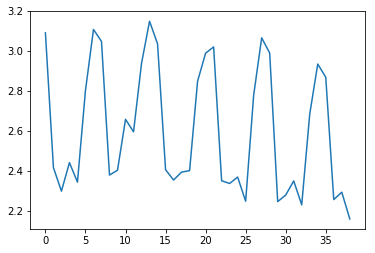

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.492888   
air_0164b9927d20bcc3_2017-04-23              1.751212   
air_0241aa3964b7f861_2017-04-23              2.406002   
air_0328696196e46f18_2017-04-23              2.060015   
air_034a3d5b40d5b1b1_2017-04-23              3.409133   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23  11.096156  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   4.761583  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.089532  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.846087  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  29.239008

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/3000eb_ridge_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')